In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
import json
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [7]:
import numpy as np

class Particle:
    def __init__(self, position, velocity, mass, particle_type):
        self.position = np.array(position, dtype=float)
        self.velocity = np.array(velocity, dtype=float)
        self.mass = mass
        self.type = particle_type
        self.energy = self.calculate_kinetic_energy()

    def update_position(self, dt):
        self.position += self.velocity * dt

    def calculate_kinetic_energy(self):
        velocity_magnitude = np.linalg.norm(self.velocity)
        return 0.5 * self.mass * velocity_magnitude ** 2

    def detect_decay(self):
        decay_probability = min(1, self.energy / 1000)
        if np.random.random() < decay_probability:
            print(f"{self.type} particle decayed!")
            return self.decay()
        return None

    def decay(self):
        decay_products = []
        if self.type == "proton":
            decay_products.append(Particle(self.position, self.velocity / 2, self.mass / 2, "neutron"))
            decay_products.append(Particle(self.position, -self.velocity / 2, self.mass / 2, "positron"))
        return decay_products

    def display_info(self):
        print(f"Particle Type: {self.type}, Position: {self.position}, Velocity: {self.velocity}, Energy: {self.energy}")


In [8]:
class Collider:
    def __init__(self, particles):
        self.particles = particles

    def detect_collisions(self):
        collision_threshold = 1e-10  # Minimum distance for a collision to occur
        for i, p1 in enumerate(self.particles):
            for j, p2 in enumerate(self.particles[i + 1:], start=i + 1):
                distance = np.linalg.norm(p1.position - p2.position)
                if distance < collision_threshold:
                    self.handle_collision(p1, p2)

    def handle_collision(self, p1, p2):
        total_initial_momentum = p1.mass * p1.velocity + p2.mass * p2.velocity
        total_initial_energy = p1.calculate_kinetic_energy() + p2.calculate_kinetic_energy()

        if total_initial_energy > 1e12:  # Threshold for fusion energy
            self.perform_fusion(p1, p2, total_initial_momentum)
        else:
            self.apply_momentum_conservation(p1, p2)

    def apply_momentum_conservation(self, p1, p2):
        if p1.mass != p2.mass:
            v1_final = ((p1.mass - p2.mass) / (p1.mass + p2.mass)) * p1.velocity + (2 * p2.mass / (p1.mass + p2.mass)) * p2.velocity
            v2_final = ((p2.mass - p1.mass) / (p1.mass + p2.mass)) * p2.velocity + (2 * p1.mass / (p1.mass + p2.mass)) * p1.velocity
            p1.velocity = v1_final
            p2.velocity = v2_final
        else:
            p1.velocity, p2.velocity = p2.velocity, p1.velocity

    def perform_fusion(self, p1, p2, total_initial_momentum):
        combined_mass = p1.mass + p2.mass
        new_velocity = total_initial_momentum / combined_mass
        fusion_particle = Particle(position=p1.position, velocity=new_velocity, mass=combined_mass, particle_type="FusionParticle")
        self.particles.append(fusion_particle)


In [9]:
# Define some particles for testing
particles = [
    Particle(position=[0, 0, 0], velocity=[1, 0, 0], mass=1.0, particle_type="proton"),
    Particle(position=[0.1, 0, 0], velocity=[-1, 0, 0], mass=1.0, particle_type="electron"),
    Particle(position=[5, 5, 5], velocity=[-0.5, -0.5, -0.5], mass=1.0, particle_type="neutron"),
]

# Instantiate the Collider with the particles
collider = Collider(particles)

# Run the collision detection
collider.detect_collisions()

# Print the updated particle velocities after collision handling
for p in particles:
    print(f"{p.type} - Position: {p.position}, Velocity: {p.velocity}")


proton - Position: [0. 0. 0.], Velocity: [1. 0. 0.]
electron - Position: [0.1 0.  0. ], Velocity: [-1.  0.  0.]
neutron - Position: [5. 5. 5.], Velocity: [-0.5 -0.5 -0.5]


In [12]:
import os
import csv
import json

class DataLogger:
    def __init__(self, filename="simulation_data.csv", log_format="csv"):
        """
        Initializes the DataLogger to save simulation data.
        
        :param filename: The name of the output file.
        :param log_format: The format to save the data, either 'csv' or 'json'.
        """
        self.filename = filename
        self.log_format = log_format
        self.data = []
        
        # Create a new file or append if it already exists
        if log_format == "csv":
            self.headers = ["Time", "Event_Type", "Particle_Type", "Particle_ID", "X", "Y", "Z", "VX", "VY", "VZ", "Energy", "Involved_Particles"]
            self._initialize_csv()
        elif log_format == "json":
            self._initialize_json()
        else:
            raise ValueError("Log format must be either 'csv' or 'json'.")

    def _initialize_csv(self):
        """Initialize CSV file with headers if not already present."""
        if not os.path.isfile(self.filename):
            with open(self.filename, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(self.headers)

    def _initialize_json(self):
        """Initialize JSON file with an empty list if not already present."""
        if not os.path.isfile(self.filename):
            with open(self.filename, mode='w') as file:
                json.dump([], file)

    def log_collision(self, time, particle1, particle2):
        """Log collision event."""
        event = {
            "Time": time,
            "Event_Type": "Collision",
            "Particle_Type": particle1.type,
            "Particle_ID": f"{particle1.type}_{id(particle1)}",
            "X": particle1.position[0],
            "Y": particle1.position[1],
            "Z": particle1.position[2],
            "VX": particle1.velocity[0],
            "VY": particle1.velocity[1],
            "VZ": particle1.velocity[2],
            "Energy": particle1.energy,
            "Involved_Particles": [f"{particle1.type}_{id(particle1)}", f"{particle2.type}_{id(particle2)}"]
        }
        self._save_event(event)

    def log_decay(self, time, particle):
        """Log particle decay event."""
        event = {
            "Time": time,
            "Event_Type": "Decay",
            "Particle_Type": particle.type,
            "Particle_ID": f"{particle.type}_{id(particle)}",
            "X": particle.position[0],
            "Y": particle.position[1],
            "Z": particle.position[2],
            "VX": particle.velocity[0],
            "VY": particle.velocity[1],
            "VZ": particle.velocity[2],
            "Energy": particle.energy,
            "Involved_Particles": [f"{particle.type}_{id(particle)}"]
        }
        self._save_event(event)

    def log_fusion(self, time, fusion_particle, involved_particles):
        """Log fusion event."""
        event = {
            "Time": time,
            "Event_Type": "Fusion",
            "Particle_Type": fusion_particle.type,
            "Particle_ID": f"{fusion_particle.type}_{id(fusion_particle)}",
            "X": fusion_particle.position[0],
            "Y": fusion_particle.position[1],
            "Z": fusion_particle.position[2],
            "VX": fusion_particle.velocity[0],
            "VY": fusion_particle.velocity[1],
            "VZ": fusion_particle.velocity[2],
            "Energy": fusion_particle.energy,
            "Involved_Particles": [f"{p.type}_{id(p)}" for p in involved_particles]
        }
        self._save_event(event)

    def _save_event(self, event):
        """Save event in the appropriate format (CSV or JSON)."""
        if self.log_format == "csv":
            self.data.append(event)
            with open(self.filename, mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([event["Time"], event["Event_Type"], event["Particle_Type"], event["Particle_ID"], 
                                 event["X"], event["Y"], event["Z"], event["VX"], event["VY"], event["VZ"], 
                                 event["Energy"], ";".join(event["Involved_Particles"])])

        elif self.log_format == "json":
            with open(self.filename, mode='r') as file:
                data = json.load(file)
            data.append(event)
            with open(self.filename, mode='w') as file:
                json.dump(data, file)

    def export_data(self):
        """Export collected data (CSV or JSON)."""
        return self.data


In [13]:
# Create some example particles for the test
particles = [
    Particle(position=[0, 0, 0], velocity=[1, 0, 0], mass=1.0, particle_type="proton"),
    Particle(position=[1, 0, 0], velocity=[-1, 0, 0], mass=1.0, particle_type="electron"),
]

# Instantiate the DataLogger
data_logger = DataLogger(filename="test_data.csv", log_format="csv")

# Simulate a collision event (just for testing)
# Let's log the collision between the two particles at time = 0
data_logger.log_collision(time=0, particle1=particles[0], particle2=particles[1])

# Check the file to see if data is saved correctly
print("Logging complete, check 'test_data.csv' for logged events.")


Logging complete, check 'test_data.csv' for logged events.


In [14]:
import pandas as pd

# Load and display the CSV data
df = pd.read_csv('test_data.csv')
print("Logged data from test_data.csv:")
print(df)


Logged data from test_data.csv:
   Time Event_Type   Particle_Type                   Particle_ID    X    Y  \
0     0  Collision          proton          proton_2582810365232  0.0  0.0   
1     0  Collision          proton          proton_2582810900560 -5.0 -5.0   
2     1      Decay          proton          proton_2582810900560 -5.0 -5.0   
3     2     Fusion  FusionParticle  FusionParticle_2582810363216  0.0  0.0   
4     0  Collision          proton          proton_2297105116800  0.0  0.0   

     Z   VX   VY   VZ  Energy                           Involved_Particles  
0  0.0  1.0  1.0  1.0     1.5  proton_2582810365232;electron_2582810363216  
1 -5.0  1.0  1.0  1.0     1.5  proton_2582810900560;electron_2582810900224  
2 -5.0  1.0  1.0  1.0     1.5                         proton_2582810900560  
3  0.0  0.0  0.0  0.0     0.0  proton_2582810900560;electron_2582810900224  
4  0.0  1.0  0.0  0.0     0.5  proton_2297105116800;electron_2297105116320  


In [15]:
# Preprocess the data for machine learning
def preprocess_data(df):
    # Ensure that 'Energy' is numeric
    df['Energy'] = pd.to_numeric(df['Energy'], errors='coerce')
    
    # Convert 'Involved_Particles' into a count of involved particles
    df['Involved_Particles_Count'] = df['Involved_Particles'].apply(lambda x: len(x.split(';')))
    
    # Selecting features for prediction (we'll use Energy and Involved_Particles_Count)
    X = df[['Energy', 'Involved_Particles_Count']]
    
    # Target variable: Particle_Type (what we want to predict)
    y = df['Particle_Type']
    
    return X, y

# Load the data from CSV
df = pd.read_csv('test_data.csv')

# Preprocess the data
X, y = preprocess_data(df)

# Check the preprocessed data
print("Features (X) and Target (y) after preprocessing:")
print(X.head())
print(y.head())


Features (X) and Target (y) after preprocessing:
   Energy  Involved_Particles_Count
0     1.5                         2
1     1.5                         2
2     1.5                         1
3     0.0                         2
4     0.5                         2
0            proton
1            proton
2            proton
3    FusionParticle
4            proton
Name: Particle_Type, dtype: object


Classification Report:
              precision    recall  f1-score   support

      proton       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Confusion Matrix:
[[1]]


<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

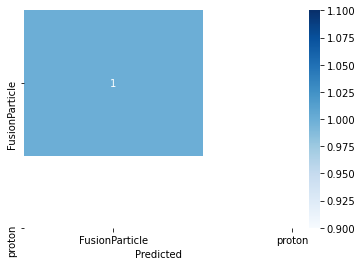

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 4: Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Best score found:  0.8875
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.91      0.83      0.87        12

    accuracy                           0.85        20
   macro avg       0.84      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20

Confusion Matrix:
[[ 7  1]
 [ 2 10]]


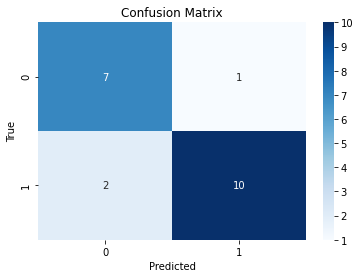

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Step 1: Create a sample dataset with sufficient samples
# Generating a synthetic classification dataset with more features
X, y = make_classification(n_samples=100, n_features=5, n_informative=3, n_classes=2, random_state=42)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Step 4: Perform GridSearchCV to tune hyperparameters
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
}

# Initialize GridSearchCV with 5-fold cross-validation (works with 100 samples)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Step 5: Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Step 6: Evaluate the model using the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Step 7: Evaluate the model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 8: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Step 9: Plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=grid_search.best_estimator_.classes_, yticklabels=grid_search.best_estimator_.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
